In [1]:
from src.dispersion import * 
from src.VSH import * 
from src.extra_special import * 
from src.fields import (
    E_,
    H_,
    E_cart_,
    H_cart_
)
from src.AM import *
from src.AM_v2 import *
from src.misc import *

import numpy as np
import scipy.constants as const
import scipy.special as sp
from scipy import integrate
from scipy.misc import derivative
from cxroots import Rectangle, AnnulusSector, Circle
import cxroots
from icecream import ic

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe  # for text effects 
plt.rcParams.update({'font.size': 18})

Z_0 = np.sqrt(const.mu_0 / const.epsilon_0)  # vacuum impedance

Let us calculate 
$$
[\mathbf{j}^2] = \frac{\langle \psi | \hat{\mathbf{J}}^2 | \psi \rangle}{\langle \psi |\psi \rangle}
$$
for $\psi$ being just a VSH.

In [3]:
m, n = 1, 2

r, theta, phi = 100, 0.2, 0.3
x, y, z = sph2cart(r, theta, phi)


E_cart = fieldTrasformSph2cart(lambda r, theta, phi: Mmn(m, n, r, theta, phi, superscript=3))
#E_cart = fieldTrasformSph2cart(lambda r, theta, phi:  Xmn_Jackson(m, n, r, theta, phi))
H_cart = fieldTrasformSph2cart(lambda r, theta, phi: -1j * Nmn(m, n, r, theta, phi, superscript=3))

j2 = j2_canonical(x, y, z, E_cart, H_cart, part="both", dh=1e-4)
ic(
    np.real(j2),
    np.imag(j2),
    n*(n+1),
    helicity_(x, y, z, E_cart, H_cart)
);

ic| np.real(j2): 5.803869019823922
    np.imag(j2): -2.9965502613203125
    n*(n+1): 6
    helicity_(x, y, z, E_cart, H_cart): 0.9980375369587333


/usr/lib64/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


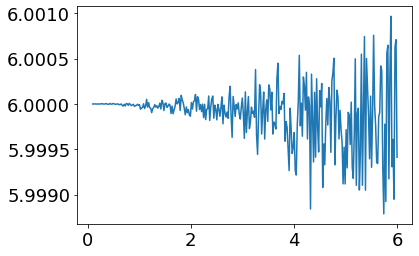

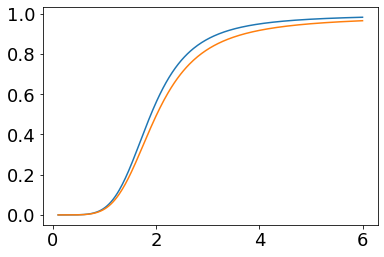

In [8]:
r, theta, phi = 100, 0.2, 0.3
x, y, z = sph2cart(r, theta, phi)

rr = np.linspace(0.1, stop=6, num=300)

jj22 = []
hh = []
hh2 = []
for r in rr:
    x, y, z = sph2cart(r, theta, phi)
    x2, y2, z2 = sph2cart(r, 1.4*theta, phi)
    
    jj22.append(j2_canonical(x, y, z, E_cart, H_cart, part="both", dh=1e-4))
    hh.append(helicity_(x, y, z, E_cart, H_cart))
    hh2.append(helicity_(x2, y2, z2, E_cart, H_cart))
    
plt.plot(rr, jj22)
plt.show()
plt.plot(rr, hh)
plt.plot(rr, hh2)
plt.show()


# Является ли M(r) соб. функцией j^2 интегрально?

In [4]:
m, n = 2, 2

r, theta, phi = 1, 0.5, 3
x, y, z = sph2cart(r, theta, phi)


E_cart = fieldTrasformSph2cart(lambda r, theta, phi: Mmn(m, n, r, theta, phi, superscript=1))
#E_cart = fieldTrasformSph2cart(lambda r, theta, phi: Xmn_Jackson(m, n, r, theta, phi))
H_cart = fieldTrasformSph2cart(lambda r, theta, phi: -1j * Nmn(m, n, r, theta, phi, superscript=1))

j2func = lambda x,y,z: np.real(j2_canonical(x, y, z, E_cart, H_cart, part="electric", dh=1e-4))
wfunc = lambda x,y,z: np.real(w_canonical(x, y, z, E_cart, H_cart, part="electric", dh=1e-4))

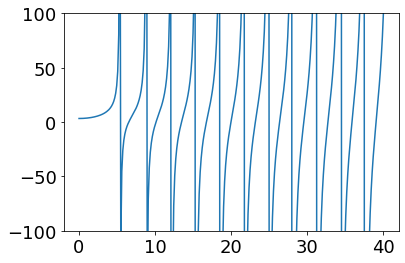

In [20]:
rr = np.linspace(0, stop=40, num=300)
theta, phi = 0.5, 2

jj22 = []
for r in rr:
    jj22.append(j2func(r, theta, phi))

plt.plot(rr, jj22)
plt.ylim(-100, 100)
plt.show()

In [5]:
ranges = [
    [-3, 3], 
    [-3, 3], 
    [-3, 3]
]

int_j2 = integrate.nquad(
    j2func, 
    ranges,
    opts={'epsrel':1e-2, 'points':[0,0,0], 'limit':20}
)[0]

int_w = integrate.nquad(
    wfunc, 
    ranges,
    opts={'epsrel':1e-2, 'points':[0,0,0], 'limit':20}
)[0]

In [6]:
int_j2 / int_w**2

0.7797097268959426

In [7]:
def AM_density(x, y, z, fE, fH):
    r = np.array([x, y, z])
    return 1/(4*np.pi) * np.cross(
        r, 
        0.5 * np.real(np.cross(np.conj(fE(x,y,z)), fH(x,y,z)))
    )

def W_density(x, y, z, fE, fH):
    E = fE(x,y,z)
    H = fH(x,y,z)
    
    EE = np.linalg.norm(E)**2
    HH = np.linalg.norm(H)**2
    
    return 1/(16*np.pi) * (EE + HH) 

In [8]:
W_density(1, 2, 3, E_cart, H_cart)

0.0006964898894658734

In [9]:
m, n = 1, 1

r, theta, phi = 1, 0.5, 3
x, y, z = sph2cart(r, theta, phi)


E_cart = fieldTrasformSph2cart(lambda r, theta, phi: Mmn(m, n, r, theta, phi, superscript=1))
#E_cart = fieldTrasformSph2cart(lambda r, theta, phi: Xmn_Jackson(m, n, r, theta, phi))
H_cart = fieldTrasformSph2cart(lambda r, theta, phi: -1j * Nmn(m, n, r, theta, phi, superscript=1))


ranges = [
    [-10, 10], 
    [-10, 10], 
    [-10, 10]
]

AMx = integrate.nquad(
    lambda x,y,z: AM_density(x, y, z, E_cart, H_cart)[0], 
    ranges,
    opts={'epsrel':1e-2, 'points':[0,0,0], 'limit':20}  
)[0]

AMy = integrate.nquad(
    lambda x,y,z: AM_density(x, y, z, E_cart, H_cart)[1], 
    ranges,
    opts={'epsrel':1e-2, 'points':[0,0,0], 'limit':20}  
)[0]

AMz = integrate.nquad(
    lambda x,y,z: AM_density(x, y, z, E_cart, H_cart)[2], 
    ranges,
    opts={'epsrel':1e-2, 'points':[0,0,0], 'limit':20}  
)[0]

W = integrate.nquad(
    lambda x,y,z: W_density(x, y, z, E_cart, H_cart), 
    ranges,
    opts={'epsrel':1e-2, 'points':[0,0,0], 'limit':20}  
)[0]

AM2 = AMx**2 + AMy**2 + AMz**2 

ic(
    AM2,
    W**2,
    AM2/W**2,
    n*(n+1)
);

ic| AM2: 0.2343347429670155
    W**2: 0.23298644499830698
    AM2/W**2: 1.0057870232266874
    n*(n+1): 2


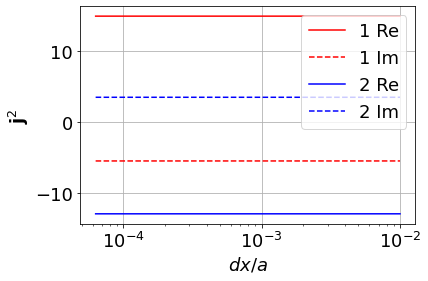

ic| (n+1)*(n+2): 20
    n*(n+1): 12
    m**2: 1
    (m+1)**2: 4
    np.real(j2canon)[0]: 14.986194787219512
    np.imag(j2canon)[0]: -5.505515618307019
    np.real(j2canon2)[0]: -12.986193140923866
    np.imag(j2canon2)[0]: 3.5055144621855914


In [4]:
eps_dielectric = 10 + 0.0j
mu_dielectric = 1.0 + 0.0j
eps_out = 1
mu_out = 1

a = 1
omega = 2*const.speed_of_light

n, m = 3, 1
#m = 1

mode_type = "TE"
particle_type = "dielectric"

r = 2.1*a
theta = 1.2
phi = 1.0

x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta) 

epshSpace = 10.0**np.linspace(-4.2, stop=-2, num=7)
j2canon = np.zeros(np.size(epshSpace)) + 0.0j
j2canon2 = np.zeros(np.size(epshSpace)) + 0.0j

part = "electric"


for (i, epsh) in enumerate(epshSpace):
    J2canon = J2_canonical_(
        m, n, x, y, z, mode_type, a, 
        omega, particle_type, eps_out, mu_out, eps_dielectric, mu_dielectric, part=part, epsh=epsh
    )
    J2canon2 = J2_canonical2_(
        m, n, x, y, z, mode_type, a, 
        omega, particle_type, eps_out, mu_out, eps_dielectric, mu_dielectric, part=part, epsh=epsh
    )
    W = W_(
        m, n, r, theta, phi, mode_type, a, 
        omega, particle_type, eps_out, mu_out, eps_dielectric, mu_dielectric, part=part
    )
    j2canon[i] = J2canon / (W/np.abs(omega))
    j2canon2[i] = J2canon2 / (W/np.abs(omega))


plt.plot(epshSpace, np.real(j2canon), c="red", label="1 Re")
plt.plot(epshSpace, np.imag(j2canon), c="red", ls="--", label="1 Im")

plt.plot(epshSpace, np.real(j2canon2), c="blue", label="2 Re")
plt.plot(epshSpace, np.imag(j2canon2), c="blue", ls="--", label="2 Im")

plt.xscale("log")
#plt.yscale("log")
plt.legend()
plt.ylabel("$\mathbf{j}^2$")
plt.xlabel("$dx/a$")
plt.grid()
#plt.ylim(0, 12)
plt.show()


ic(
    (n+1)*(n+2),
    n*(n+1),
    m**2,
    (m+1)**2,
    np.real(j2canon)[0], 
    np.imag(j2canon)[0],
    np.real(j2canon2)[0], 
    np.imag(j2canon2)[0]
);